In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
# ============================================================================
# 1. CRITIC ARCHITECTURE (NOT Discriminator!)
# ============================================================================

class Critic(nn.Module):
    """WGAN uses Critic (not Discriminator) - outputs scalar score"""
    def __init__(self):
        super(Critic, self).__init__()
        
        # No sigmoid at the end!
        self.model = nn.Sequential(
            # Input: 1x28x28
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 64x14x14
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x7x7
            nn.BatchNorm2d(128),  # BatchNorm in critic is OK
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x3x3
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1)  # Output: scalar score
            # NO SIGMOID! We want real-valued scores
        )
        
        # Weight initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, img):
        validity = self.model(img)
        return validity  # Raw scores, not probabilities!

# class SimpleCritic(nn.Module):
#     """Very simple critic (less powerful)"""
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(1, 32, 4, 2, 1),  # 32x14x14
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(32, 64, 4, 2, 1),  # 64x7x7
#             nn.LeakyReLU(0.2),
#             nn.Conv2d(64, 128, 4, 2, 1),  # 128x3x3
#             nn.LeakyReLU(0.2),
#             nn.Flatten(),
#             nn.Linear(128*3*3, 1)
#         )
    
#     def forward(self, x):
#         return self.model(x)

In [21]:
# ============================================================================
# 2. GENERATOR ARCHITECTURE
# ============================================================================

class Generator(nn.Module):
    """Generator producing exactly 28x28 MNIST images"""
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        
        self.z_dim = z_dim
        
        self.model = nn.Sequential(
            # Step 1: 1x1 → 4x4
            # Formula: (1-1)*1 - 2*0 + 1*(4-1) + 1 = 4
            # nn.ConvTranspose2d(z_dim, 512, kernel_size=7, stride=1, padding=0, bias=False),
            # nn.BatchNorm2d(512),
            # nn.ReLU(True),
            
            # Step 2: 4x4 → 7x7
            # Formula: (4-1)*2 - 2*1 + 1*(4-1) + 1 = 7
            nn.ConvTranspose2d(z_dim, 256, kernel_size=7, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Step 3: 7x7 → 14x14
            # Formula: (7-1)*2 - 2*1 + 1*(4-1) + 1 = 14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Step 4: 14x14 → 28x28
            # Formula: (14-1)*2 - 2*1 + 1*(4-1) + 1 = 28
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Final: 28x28 → 28x28 (maintain size)
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, z):
        z = z.view(z.size(0), self.z_dim, 1, 1)
        return self.model(z)

In [22]:
class ResidualBlock(nn.Module):
    """Basic ResNet block for Generator"""
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 
                     kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU(True),
            nn.Conv2d(out_channels, out_channels, 
                     kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True)
        )
        
        # Shortcut connection if channels change
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                         kernel_size=1, stride=1, bias=False),
                nn.InstanceNorm2d(out_channels, affine=True)
            )
        
    def forward(self, x):
        return F.relu(self.block(x) + self.shortcut(x))

class GeneratorComplex(nn.Module):
    """Enhanced Generator for MNIST"""
    def __init__(self, z_dim=100, init_channels=512):
        super(GeneratorComplex, self).__init__()
        self.z_dim = z_dim
        
        # Start from 7x7 instead of 4x4 for MNIST
        self.init_size = 7
        self.init_channels = init_channels
        
        # Project and reshape noise to 7x7
        self.fc = nn.Linear(z_dim, init_channels * self.init_size * self.init_size)
        
        # Main network with residual blocks
        self.network = nn.Sequential(
            # Initial reshape: (batch, 512, 7, 7)
            
            # Residual Block 1 (7x7 → 7x7)
            ResidualBlock(init_channels, init_channels),
            
            # Upsample to 14x14
            nn.ConvTranspose2d(init_channels, init_channels//2, 
                              kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(init_channels//2, affine=True),
            nn.ReLU(True),
            
            # Residual Block 2 (14x14 → 14x14)
            ResidualBlock(init_channels//2, init_channels//2),
            
            # Upsample to 28x28
            nn.ConvTranspose2d(init_channels//2, init_channels//4, 
                              kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(init_channels//4, affine=True),
            nn.ReLU(True),
            
            # Residual Block 3 (28x28 → 28x28)
            ResidualBlock(init_channels//4, in   it_channels//4),
            
            # Final convolution to 1 channel
            nn.Conv2d(init_channels//4, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )
        
        # self._initialize_weights()
    
    def forward(self, z):
        # Project noise
        h = self.fc(z)
        h = h.view(h.size(0), self.init_channels, self.init_size, self.init_size)
        return self.network(h)



In [23]:
# ============================================================================
# 3. GRADIENT PENALTY (for WGAN-GP)
# ============================================================================

def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN-GP"""
    batch_size = real_samples.size(0)
    
    # Generate random interpolation between real and fake samples
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    # Get critic scores for interpolated samples
    critic_interpolated = critic(interpolated)
    # Calculate gradients of critic scores w.r.t. interpolated samples
    gradients = torch.autograd.grad(
        outputs=critic_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_interpolated).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute gradient penalty: (||gradients||_2 - 1)^2
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return gradient_penalty


In [24]:
# ============================================================================
# 4. TRAINING FUNCTION
# ============================================================================

def train_wgan_gp(generator, critic, dataloader, num_epochs=50, z_dim=100, 
                        n_critic=5, lambda_gp=10, sample_interval=200):
    """Clean implementation of WGAN-GP training"""
    
    # Optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=0.00001, betas=(0.5, 0.999))
    c_optimizer = optim.Adam(critic.parameters(), lr=0.00001, betas=(0.5, 0.999))
    
    # Track losses
    g_losses, c_losses, w_distances = [], [], []
    
    # Fixed noise for samples
    fixed_noise = torch.randn(64, z_dim, device=device)
    
    print(f"Training WGAN-GP for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        epoch_g_loss = 0.0
        epoch_c_loss = 0.0
        epoch_w_dist = 0.0
        g_update_count = 0
        
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (real_imgs, _) in enumerate(pbar):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            
            # ========== Train Critic ==========
            c_optimizer.zero_grad()
            
            # Generate fakes
            z = torch.randn(batch_size, z_dim, device=device)
            fake_imgs = generator(z).detach()
            
            # Critic scores
            real_scores = critic(real_imgs)
            fake_scores = critic(fake_imgs)
            
            # Gradient penalty
            gp = compute_gradient_penalty(critic, real_imgs.data, fake_imgs.data)
            
            # Critic loss
            c_loss = -torch.mean(real_scores) + torch.mean(fake_scores) + lambda_gp * gp
            
            # Wasserstein distance
            w_dist = torch.mean(real_scores) - torch.mean(fake_scores)
            
            c_loss.backward()

            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)

            c_optimizer.step()
            
            # ========== Train Generator (every n_critic steps) ==========
            g_loss_val = None
            if batch_idx % n_critic == 0:
                g_optimizer.zero_grad()
                
                z = torch.randn(batch_size, z_dim, device=device)
                gen_imgs = generator(z)
                
                g_loss = -torch.mean(critic(gen_imgs))
                g_loss.backward()
                
                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                
                g_optimizer.step()
                
                g_loss_val = g_loss.item()
                epoch_g_loss += g_loss_val
                g_update_count += 1
            
            # Update tracking
            epoch_c_loss += c_loss.item()
            epoch_w_dist += w_dist.item()
            
            # Update progress bar
            postfix_dict = {
                'C_loss': f'{c_loss.item():.4f}',
                'W_dist': f'{w_dist.item():.4f}'
            }
            
            if g_loss_val is not None:
                postfix_dict['G_loss'] = f'{g_loss_val:.4f}'
            else:
                postfix_dict['G_loss'] = '---'
            
            pbar.set_postfix(postfix_dict)
            
            # Save samples periodically
            if batch_idx % sample_interval == 0:
                with torch.no_grad():
                    samples = generator(fixed_noise).detach().cpu()
                    samples = (samples + 1) / 2  # Rescale to [0, 1]
                    
                    # Quick save
                    if batch_idx == 0 and epoch % 5 == 0:
                        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
                        for i, ax in enumerate(axes.flat):
                            ax.imshow(samples[i, 0], cmap='gray', vmin=0, vmax=1)
                            ax.axis('off')
                        plt.suptitle(f'Epoch {epoch+1}, Batch {batch_idx}', fontsize=14)
                        plt.tight_layout()
                        plt.savefig(f'/kaggle/working/wgan_epoch{epoch+1}_batch{batch_idx}.png')
                        plt.close()
        
        # Calculate epoch averages
        avg_g_loss = epoch_g_loss / max(1, g_update_count)
        avg_c_loss = epoch_c_loss / len(dataloader)
        avg_w_dist = epoch_w_dist / len(dataloader)
        
        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)
        w_distances.append(avg_w_dist)
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Critic Loss: {avg_c_loss:.4f}")
        print(f"  Generator Loss: {avg_g_loss:.4f}")
        print(f"  Wasserstein Distance: {avg_w_dist:.4f}")
        
        # Generate final samples for this epoch
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            with torch.no_grad():
                samples = generator(fixed_noise).detach().cpu()
                save_epoch_samples(samples, epoch)
    
    return generator, critic, g_losses, c_losses, w_distances


def train_wgan_gp_improved(generator, critic, dataloader, num_epochs=100, z_dim=100,
                          n_critic=5, lambda_gp=10, sample_interval=200):
    """Improved WGAN-GP training with better monitoring"""
    
    # Hyperparameters
    lr = 0.0002  # 2e-5 (slightly higher than before)
    lambda_gp = 10
    n_critic = 1
    
    # Optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.999))
    
    # Learning rate schedulers
    g_scheduler = optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.98)
    c_scheduler = optim.lr_scheduler.ExponentialLR(c_optimizer, gamma=0.98)
    
    # Track losses
    g_losses, c_losses, w_distances = [], [], []
    
    # For monitoring gradient penalty
    gp_values = []
    
    # Fixed noise for samples
    fixed_noise = torch.randn(64, z_dim, device=device)
    
    print(f"Training Improved WGAN-GP for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        epoch_g_loss = 0.0
        epoch_c_loss = 0.0
        epoch_w_dist = 0.0
        epoch_gp = 0.0
        g_update_count = 0
        
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (real_imgs, _) in enumerate(pbar):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            
            # ========== Train Critic ==========
            c_optimizer.zero_grad()
            
            z = torch.randn(batch_size, z_dim, device=device)
            fake_imgs = generator(z).detach()
            
            real_scores = critic(real_imgs)
            fake_scores = critic(fake_imgs)
            
            # Gradient penalty
            gp = compute_gradient_penalty(critic, real_imgs, fake_imgs)
            
            c_loss = -torch.mean(real_scores) + torch.mean(fake_scores) + lambda_gp * gp
            w_dist = torch.mean(real_scores) - torch.mean(fake_scores)
            
            c_loss.backward()
            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
            c_optimizer.step()
            
            # ========== Train Generator ==========
            if batch_idx % n_critic == 0:
                g_optimizer.zero_grad()
                
                z = torch.randn(batch_size, z_dim, device=device)
                gen_imgs = generator(z)
                
                g_loss = -torch.mean(critic(gen_imgs))
                g_loss.backward()
                torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                g_optimizer.step()
                
                epoch_g_loss += g_loss.item()
                g_update_count += 1
            
            # Track statistics
            epoch_c_loss += c_loss.item()
            epoch_w_dist += w_dist.item()
            epoch_gp += gp.item()
            
            # Update progress bar
            postfix = {
                'C': f'{c_loss.item():.2f}',
                'W': f'{w_dist.item():.2f}',
                'G': f'{g_loss.item():.2f}' if batch_idx % n_critic == 0 else '---',
                'GP': f'{gp.item():.2f}'
            }
            pbar.set_postfix(postfix)
        
        # Epoch averages
        avg_g_loss = epoch_g_loss / max(1, g_update_count)
        avg_c_loss = epoch_c_loss / len(dataloader)
        avg_w_dist = epoch_w_dist / len(dataloader)
        avg_gp = epoch_gp / len(dataloader)
        
        g_losses.append(avg_g_loss)
        c_losses.append(avg_c_loss)
        w_distances.append(avg_w_dist)
        gp_values.append(avg_gp)
        
        # Update learning rates
        g_scheduler.step()
        c_scheduler.step()
        
        print(f"\nEpoch {epoch+1}:")
        print(f"  W-distance: {avg_w_dist:.3f} (target: ~0)")
        print(f"  Critic Loss: {avg_c_loss:.3f}")
        print(f"  Generator Loss: {avg_g_loss:.3f}")
        print(f"  Gradient Penalty: {avg_gp:.3f}")
        print(f"  LR: {g_optimizer.param_groups[0]["lr"]:.2e}")
        
        # Generate samples every 10 epochs
        # if (epoch + 1) % 10 == 0 or epoch == 0:
        if 1:
            with torch.no_grad():
                generator.eval()
                samples = generator(fixed_noise).detach().cpu()
                generator.train()
                
                samples = (samples + 1) / 2
                
                # Plot
                fig, axes = plt.subplots(8, 8, figsize=(10, 10))
                for i, ax in enumerate(axes.flat):
                    ax.imshow(samples[i, 0], cmap='gray', vmin=0, vmax=1)
                    ax.axis('off')
                plt.suptitle(f'WGAN-GP Epoch {epoch+1}\nW-distance: {avg_w_dist:.2f}', fontsize=14)
                plt.tight_layout()
                plt.show()
        
        # Early stopping check
        if epoch > 20:
            # Check if W-distance is stabilizing
            recent_w = w_distances[-10:]
            if max(recent_w) - min(recent_w) < 2.0:
                print(f"\n✅ W-distance stabilized. Stopping early at epoch {epoch+1}")
                break
            
            # Check if we're making progress
            if avg_w_dist > 20:  # Getting worse
                print(f"\n⚠️ W-distance increasing. Consider adjusting hyperparameters.")
    
    return generator, critic, g_losses, c_losses, w_distances, gp_values

In [25]:
# ============================================================================
# 5. VISUALIZATION UTILITIES
# ============================================================================

def save_generated_images(generator, fixed_noise, epoch, batch_idx):
    """Save generated images during training"""
    generator.eval()
    with torch.no_grad():
        gen_imgs = generator(fixed_noise).detach().cpu()
    
    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = (gen_imgs + 1) / 2
    
    # Plot
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(gen_imgs[i, 0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    
    plt.suptitle(f'Epoch {epoch+1}, Batch {batch_idx}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/wgan_samples_epoch{epoch+1}_batch{batch_idx}.png')
    plt.close()
    generator.train()

def save_epoch_samples(gen_imgs, epoch):
    """Save a grid of generated images for each epoch"""
    gen_imgs = (gen_imgs + 1) / 2  # Rescale to [0, 1]
    
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(gen_imgs[i, 0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    
    plt.suptitle(f'WGAN-GP Generated MNIST Digits - Epoch {epoch+1}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/wgan_epoch_{epoch+1}.png')
    plt.close()

def plot_training_history(g_losses, c_losses, wasserstein_distances):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    epochs = range(1, len(g_losses) + 1)
    
    # Generator loss
    axes[0].plot(epochs, g_losses, 'r-', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Generator Loss')
    axes[0].set_title('Generator Training Loss')
    axes[0].grid(True, alpha=0.3)
    
    # Critic loss
    axes[1].plot(epochs, c_losses, 'b-', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Critic Loss')
    axes[1].set_title('Critic Training Loss')
    axes[1].grid(True, alpha=0.3)
    
    # Wasserstein distance
    axes[2].plot(epochs, wasserstein_distances, 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Wasserstein Distance')
    axes[2].set_title('Estimated Wasserstein Distance')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('WGAN-GP Training History', fontsize=14)
    plt.tight_layout()
    plt.savefig('/kaggle/working/wgan_training_history.png')
    plt.show()


Dataset size: 60000
Batch size: 128
Number of batches: 469


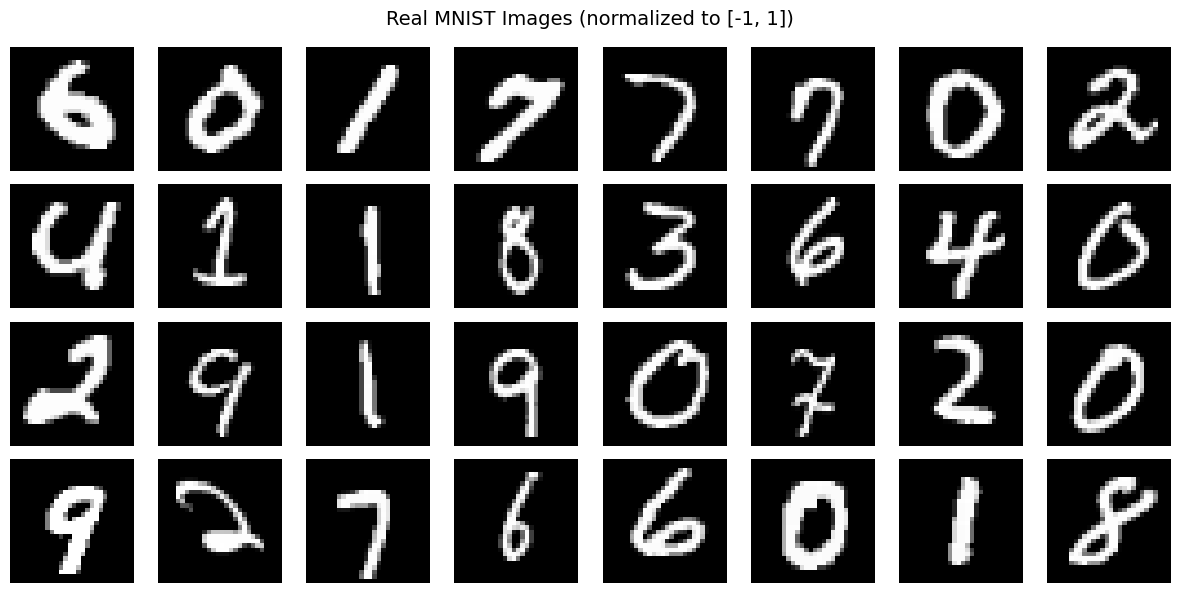

In [26]:
# ============================================================================
# 6. DATA LOADING
# ============================================================================

# Transform: normalize to [-1, 1] for tanh generator output
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # MNIST: mean=0.5, std=0.5 → [-1, 1]
])

# Load MNIST
mnist_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Create dataloader
batch_size = 128
dataloader = DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Dataset size: {len(mnist_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of batches: {len(dataloader)}")

# Visualize real images
real_images, _ = next(iter(dataloader))
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(real_images[i][0], cmap='gray', vmin=-1, vmax=1)
    ax.axis('off')
plt.suptitle('Real MNIST Images (normalized to [-1, 1])', fontsize=14)
plt.tight_layout()
plt.show()


In [27]:
# ============================================================================
# 7. INITIALIZE MODELS
# ============================================================================

# Parameters
z_dim = 100  # Noise dimension

# Create models
# generator = Generator(z_dim=z_dim).to(device)

generator = GeneratorComplex(z_dim=z_dim).to(device)
critic = Critic().to(device)
# critic = SimpleCritic().to(device)

# Print model architectures
print("\n" + "="*60)
print("GENERATOR ARCHITECTURE")
print("="*60)
print(generator)
print(f"\nTotal parameters: {sum(p.numel() for p in generator.parameters()):,}")

print("\n" + "="*60)
print("CRITIC ARCHITECTURE")
print("="*60)
print(critic)
print(f"\nTotal parameters: {sum(p.numel() for p in critic.parameters()):,}")


GENERATOR ARCHITECTURE
GeneratorComplex(
  (fc): Linear(in_features=100, out_features=25088, bias=True)
  (network): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (shortcut): Sequential()
    )
    (1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm  # Optional for spectral normalization

# If you want to use spectral normalization (recommended for WGAN-GP):
# pip install torch torchvision


TRAINING WGAN-GP
Training Improved WGAN-GP for 15 epochs...


Epoch 1/15: 100%|██████████| 469/469 [02:23<00:00,  3.28it/s, C=-1.13, W=1.20, G=2.50, GP=0.01] 



Epoch 1:
  W-distance: 0.295 (target: ~0)
  Critic Loss: -0.204
  Generator Loss: 0.413
  Gradient Penalty: 0.009
  LR: 1.96e-04


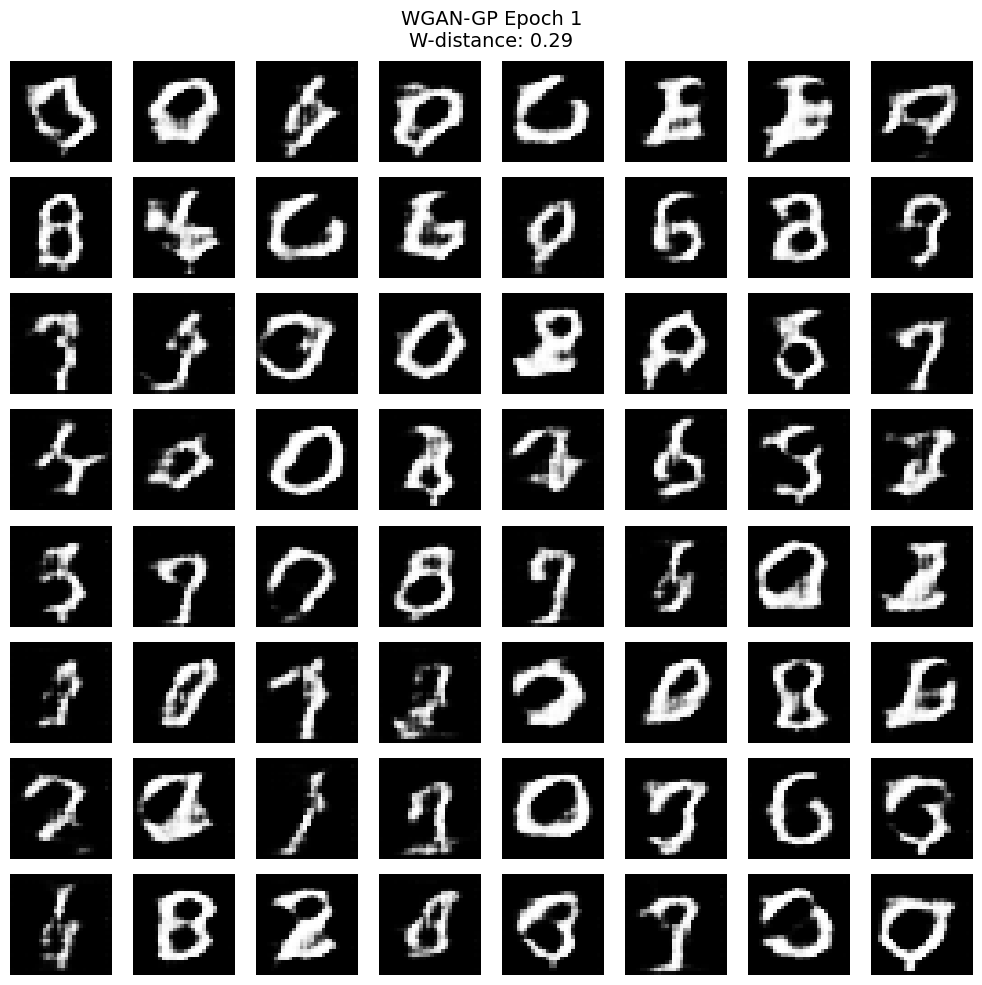

Epoch 2/15: 100%|██████████| 469/469 [02:22<00:00,  3.28it/s, C=-0.77, W=0.88, G=2.72, GP=0.01]



Epoch 2:
  W-distance: 0.695 (target: ~0)
  Critic Loss: -0.591
  Generator Loss: 2.686
  Gradient Penalty: 0.010
  LR: 1.92e-04


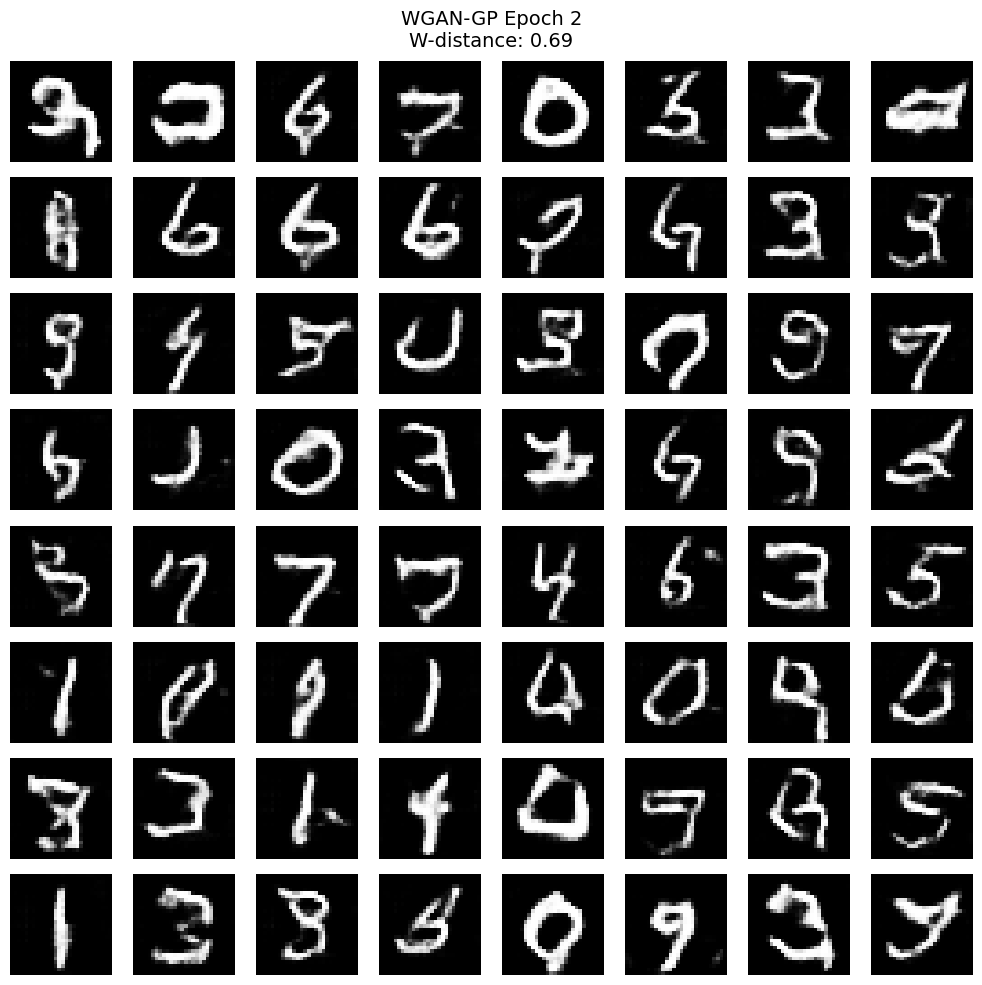

Epoch 3/15: 100%|██████████| 469/469 [02:22<00:00,  3.28it/s, C=-0.34, W=0.39, G=3.46, GP=0.01]



Epoch 3:
  W-distance: 0.278 (target: ~0)
  Critic Loss: -0.208
  Generator Loss: 3.338
  Gradient Penalty: 0.007
  LR: 1.88e-04


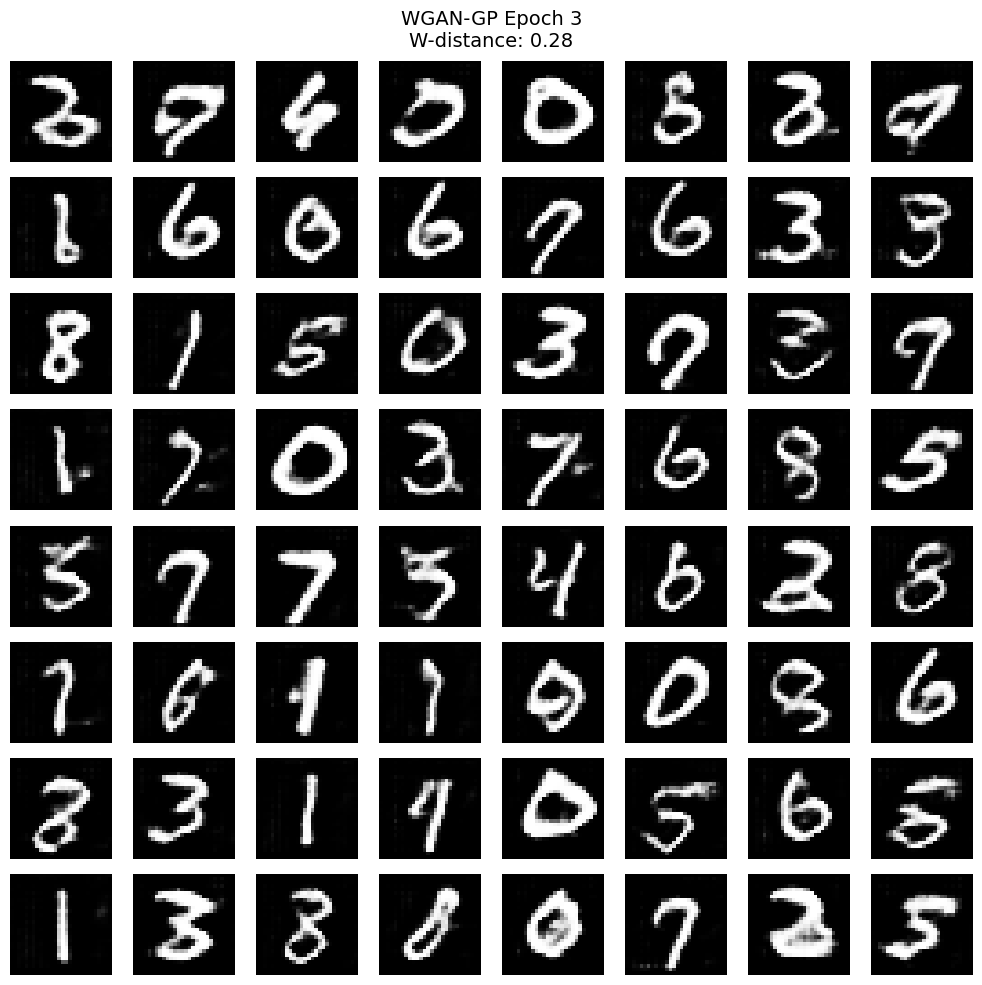

Epoch 4/15: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s, C=0.05, W=0.02, G=3.88, GP=0.01] 



Epoch 4:
  W-distance: 0.078 (target: ~0)
  Critic Loss: -0.017
  Generator Loss: 3.853
  Gradient Penalty: 0.006
  LR: 1.84e-04


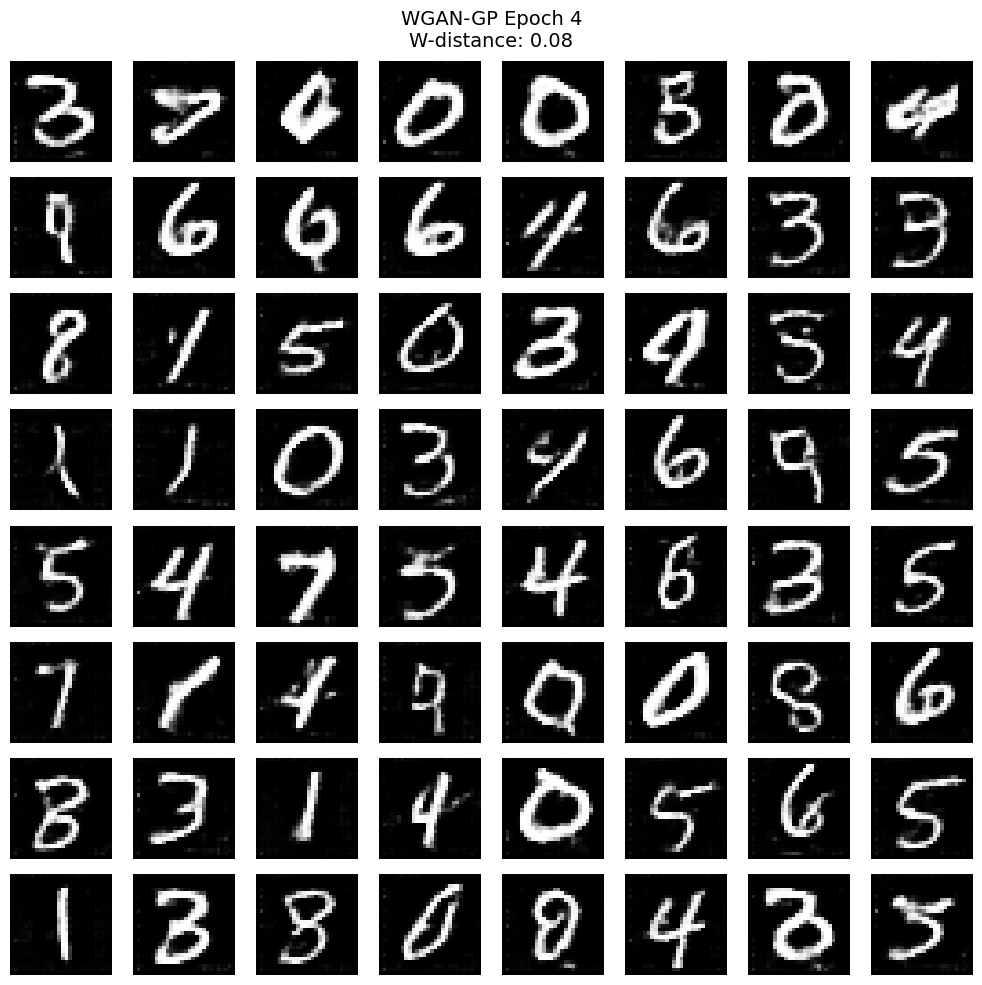

Epoch 5/15: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s, C=-0.04, W=0.09, G=5.65, GP=0.01]



Epoch 5:
  W-distance: 0.022 (target: ~0)
  Critic Loss: 0.028
  Generator Loss: 4.700
  Gradient Penalty: 0.005
  LR: 1.81e-04


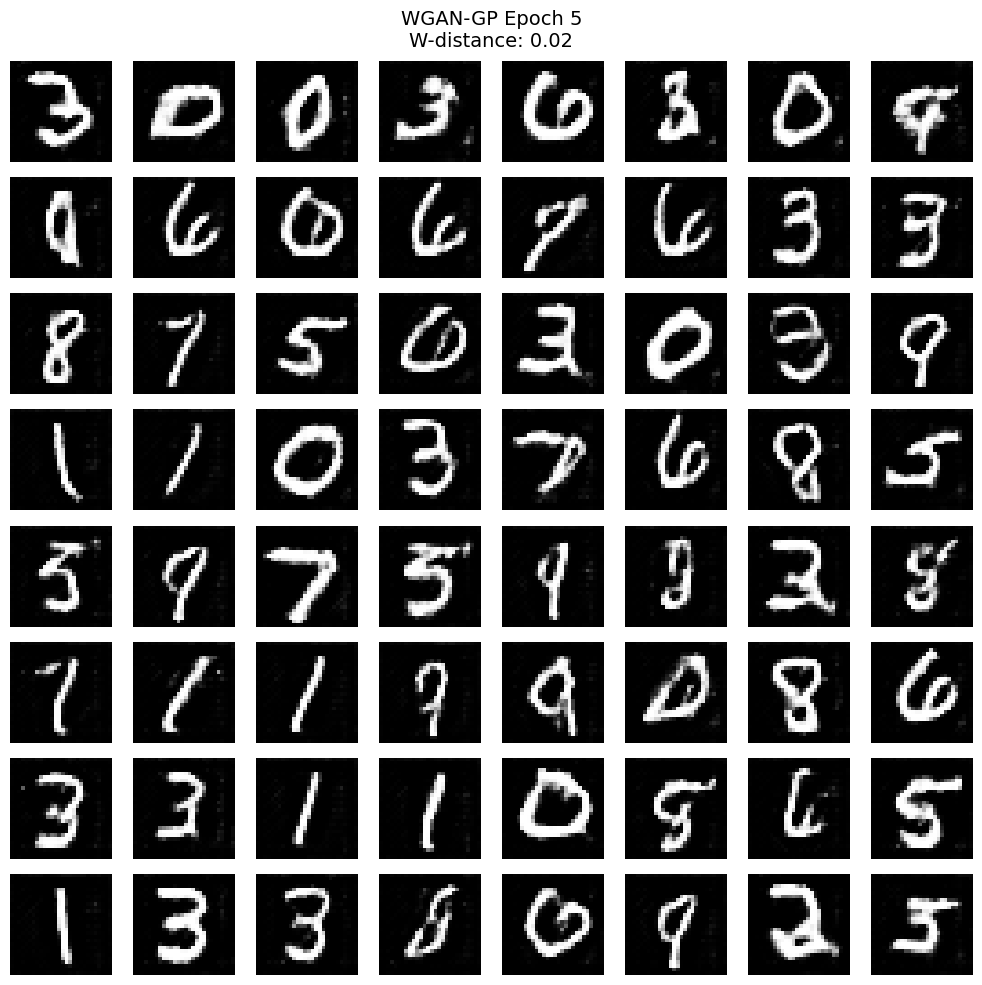

Epoch 6/15: 100%|██████████| 469/469 [02:23<00:00,  3.28it/s, C=-0.26, W=0.29, G=5.95, GP=0.00]



Epoch 6:
  W-distance: 0.069 (target: ~0)
  Critic Loss: -0.027
  Generator Loss: 5.297
  Gradient Penalty: 0.004
  LR: 1.77e-04


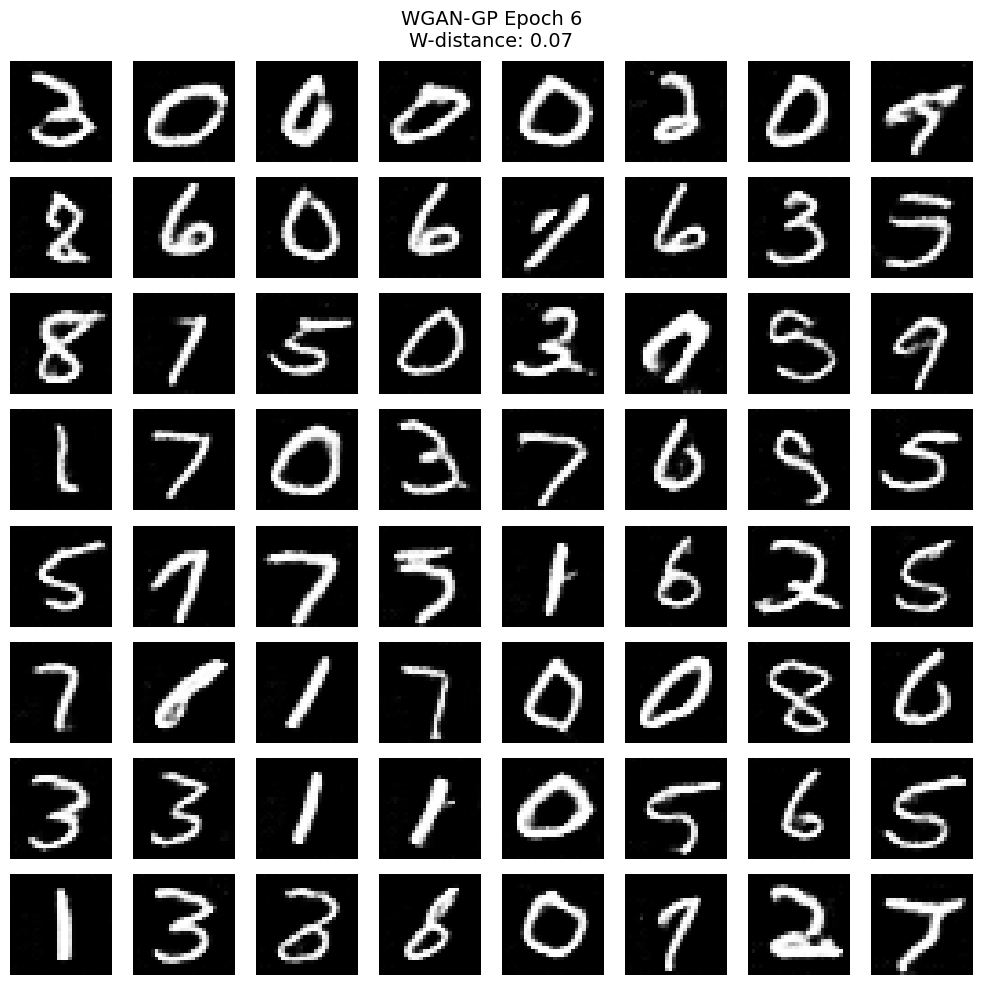

Epoch 7/15: 100%|██████████| 469/469 [02:22<00:00,  3.28it/s, C=-0.12, W=0.14, G=5.82, GP=0.00]



Epoch 7:
  W-distance: 0.067 (target: ~0)
  Critic Loss: -0.028
  Generator Loss: 5.656
  Gradient Penalty: 0.004
  LR: 1.74e-04


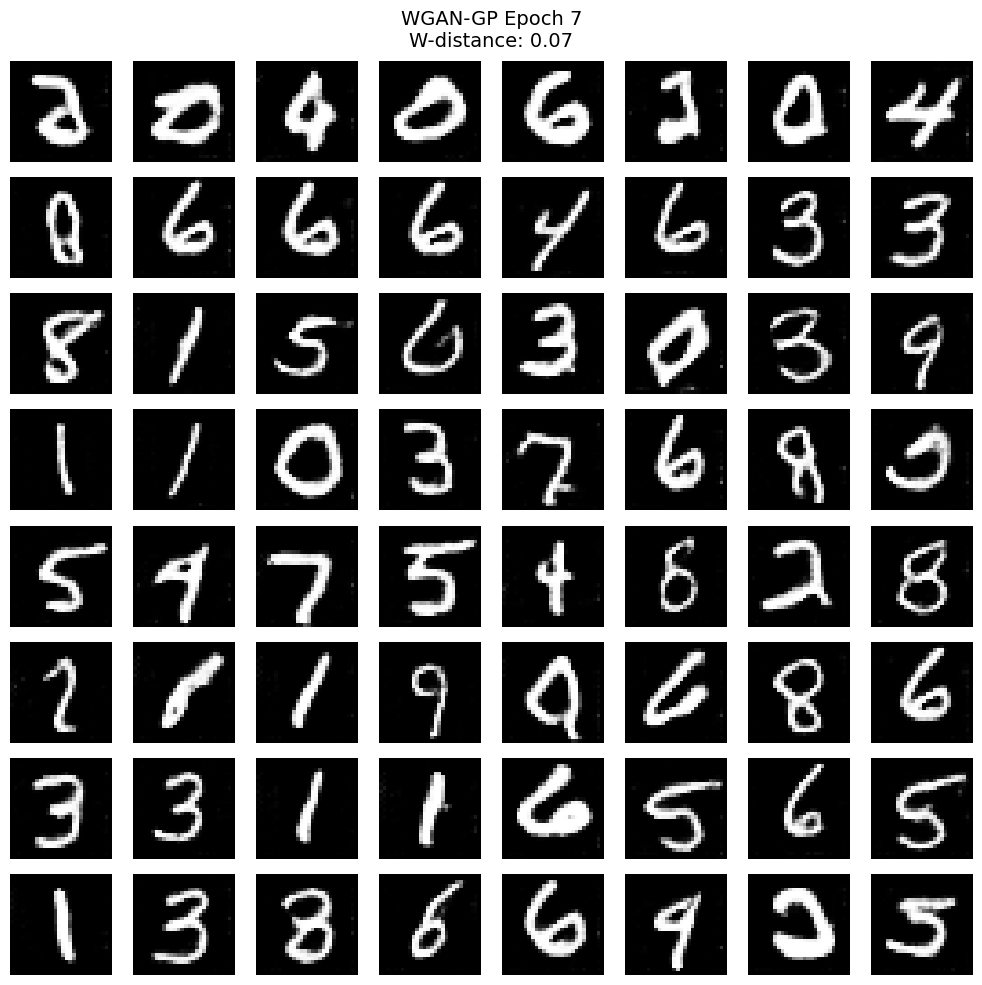

Epoch 8/15: 100%|██████████| 469/469 [02:22<00:00,  3.28it/s, C=0.24, W=-0.21, G=5.61, GP=0.00]



Epoch 8:
  W-distance: 0.058 (target: ~0)
  Critic Loss: -0.021
  Generator Loss: 6.085
  Gradient Penalty: 0.004
  LR: 1.70e-04


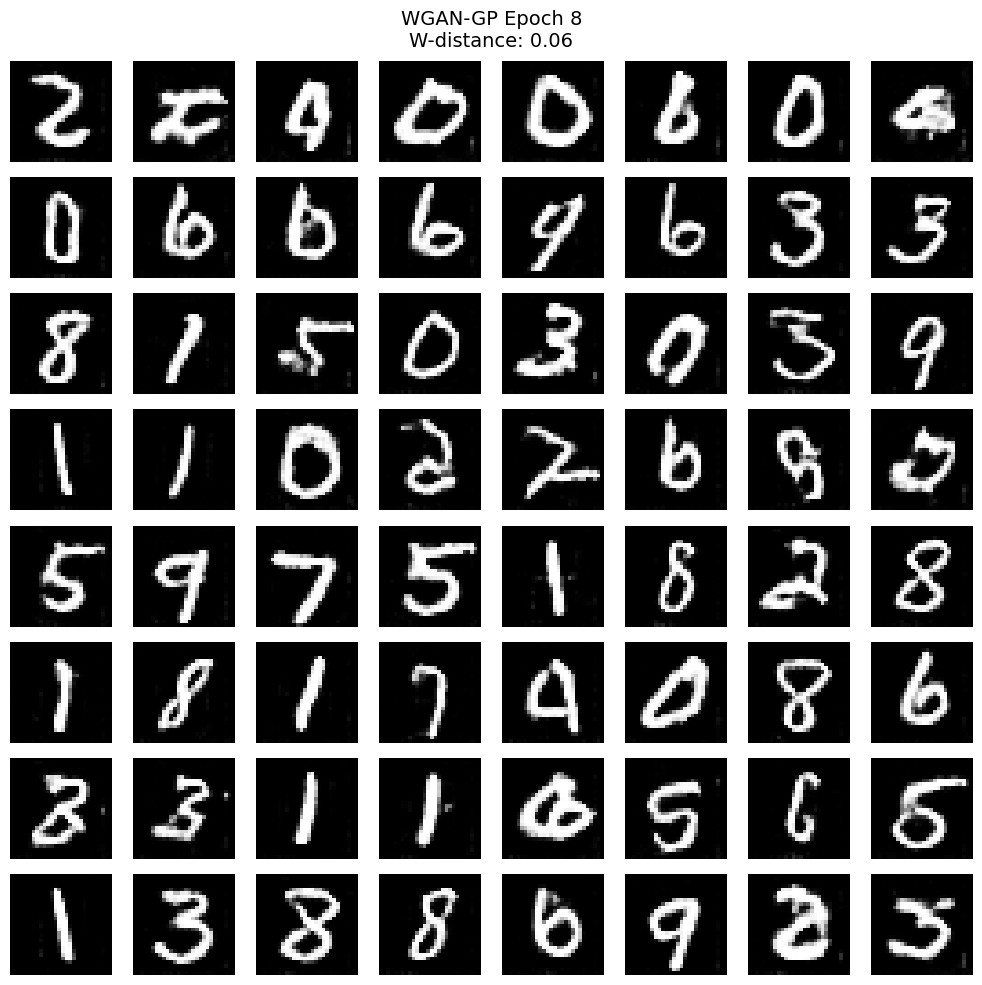

Epoch 9/15: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s, C=0.10, W=-0.08, G=5.82, GP=0.00]



Epoch 9:
  W-distance: 0.075 (target: ~0)
  Critic Loss: -0.041
  Generator Loss: 6.415
  Gradient Penalty: 0.003
  LR: 1.67e-04


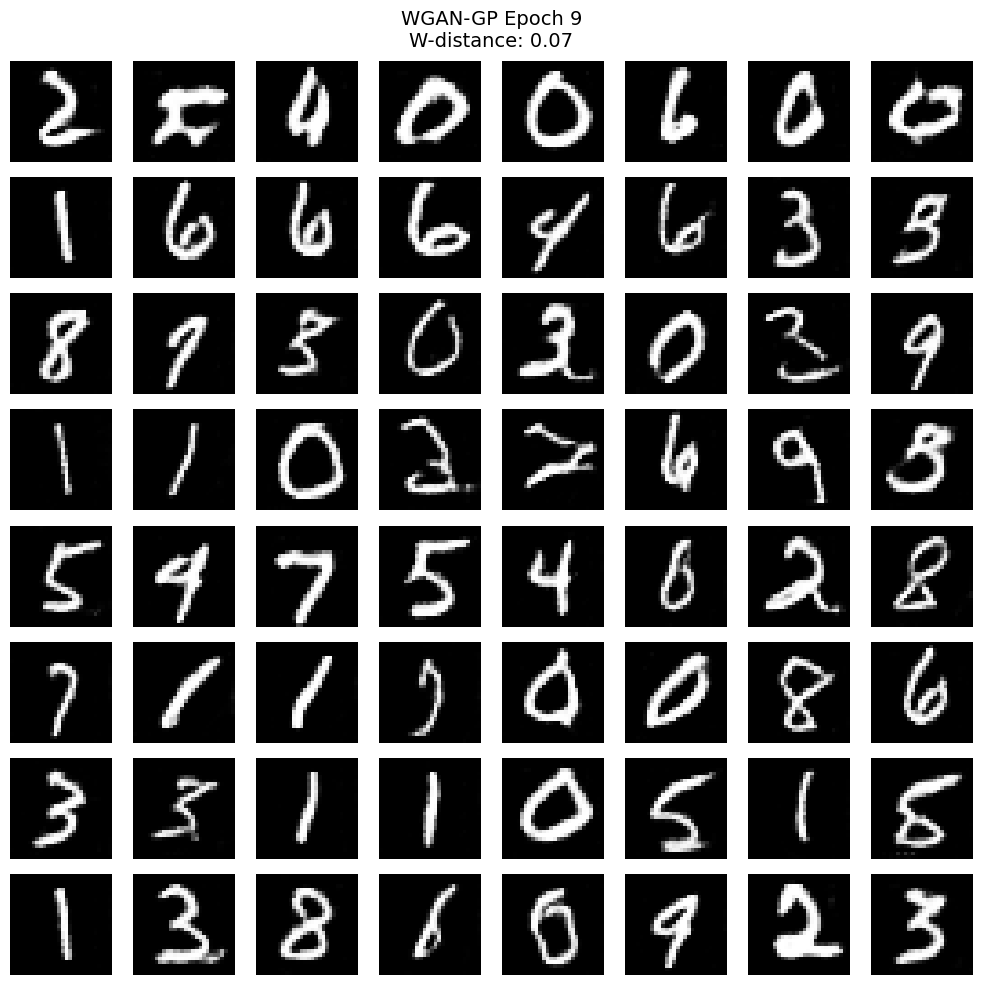

Epoch 10/15: 100%|██████████| 469/469 [02:23<00:00,  3.28it/s, C=0.18, W=-0.14, G=5.71, GP=0.00]



Epoch 10:
  W-distance: 0.043 (target: ~0)
  Critic Loss: -0.014
  Generator Loss: 6.431
  Gradient Penalty: 0.003
  LR: 1.63e-04


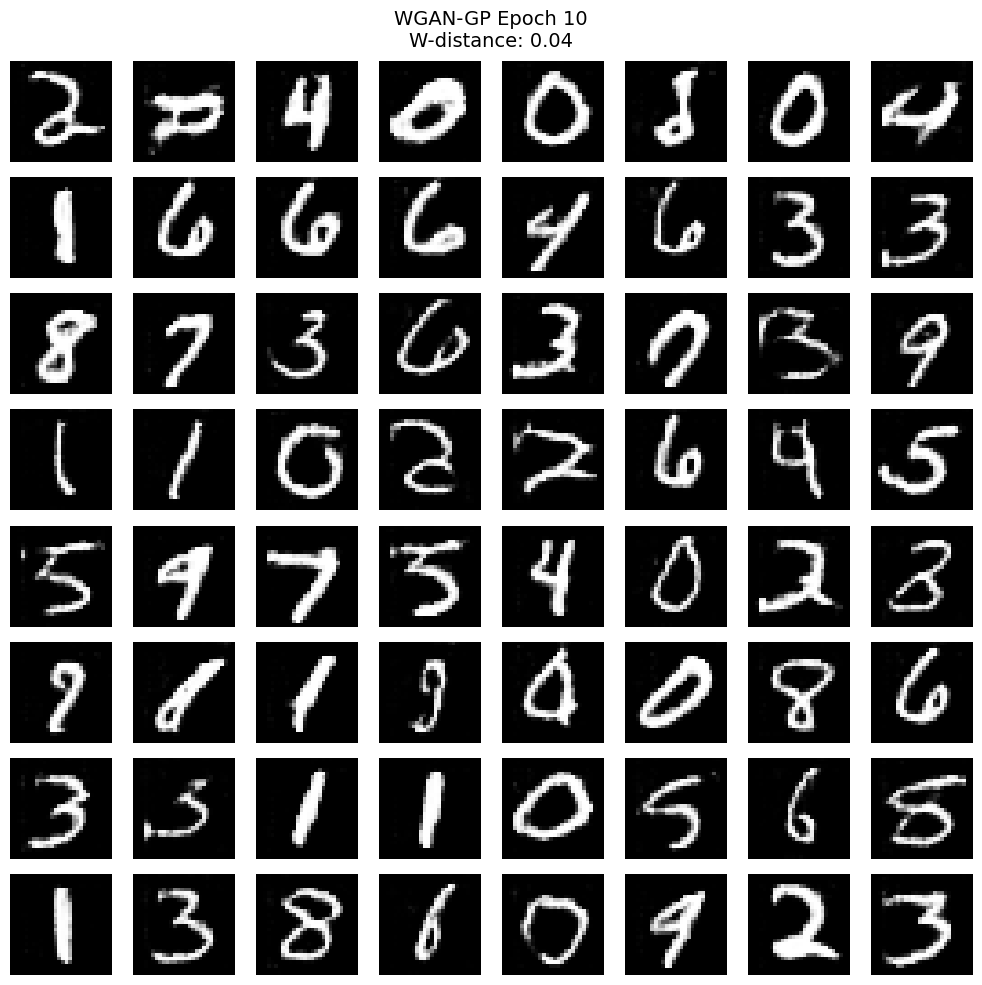

Epoch 11/15: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s, C=0.21, W=-0.18, G=7.93, GP=0.00]



Epoch 11:
  W-distance: 0.042 (target: ~0)
  Critic Loss: -0.015
  Generator Loss: 6.830
  Gradient Penalty: 0.003
  LR: 1.60e-04


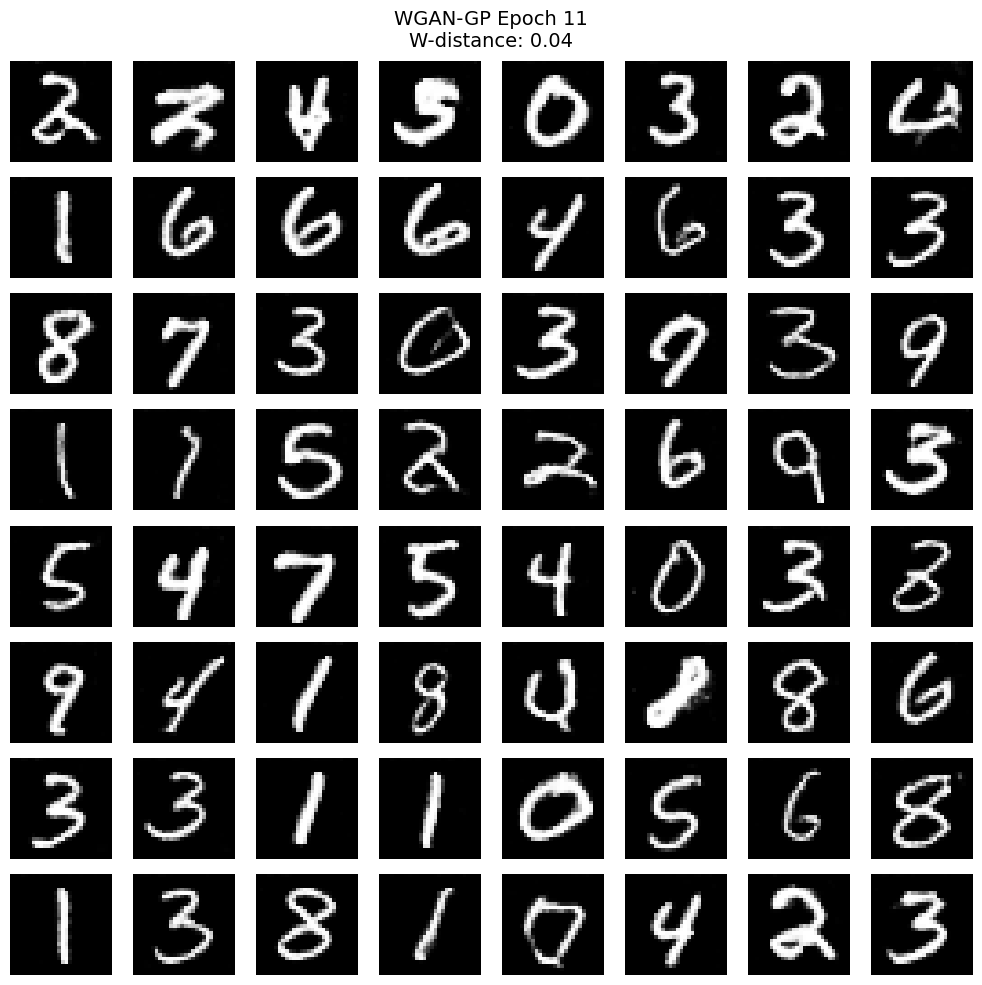

Epoch 12/15: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s, C=0.50, W=-0.47, G=7.18, GP=0.00]



Epoch 12:
  W-distance: 0.028 (target: ~0)
  Critic Loss: -0.003
  Generator Loss: 6.817
  Gradient Penalty: 0.003
  LR: 1.57e-04


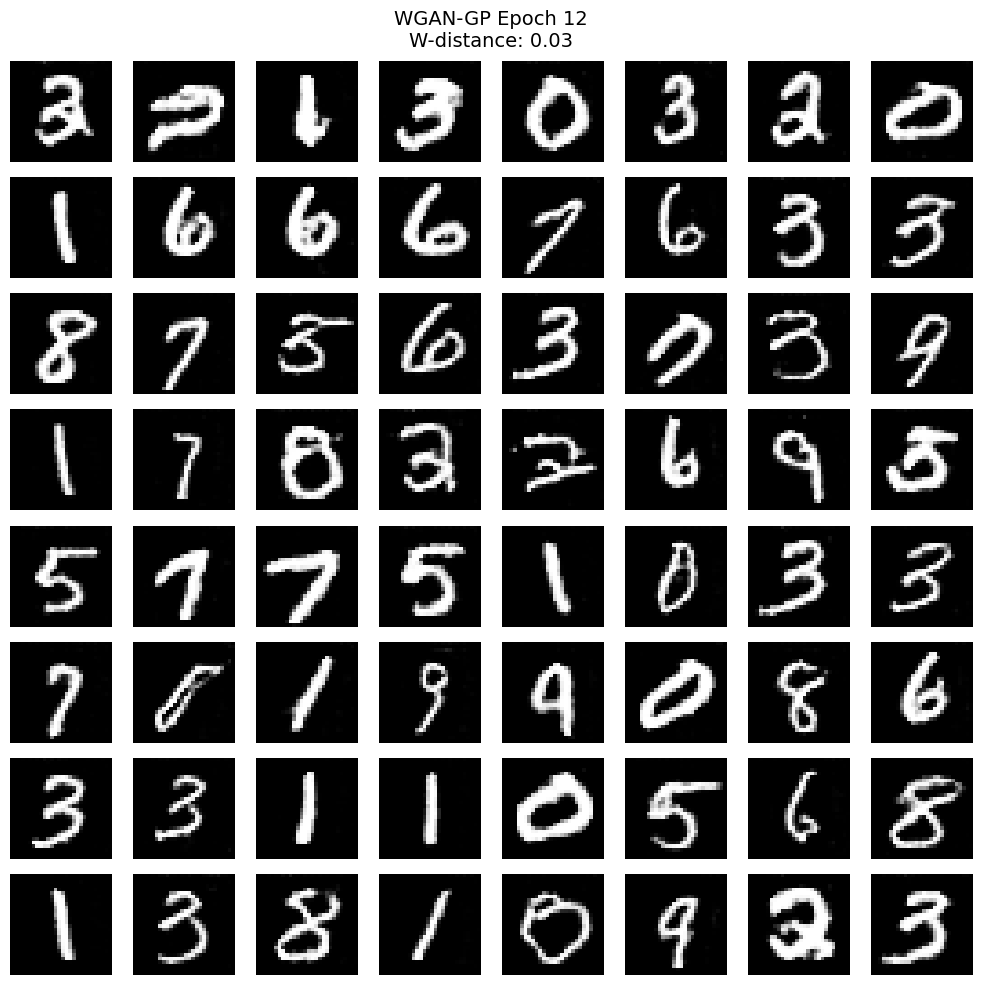

Epoch 13/15: 100%|██████████| 469/469 [02:22<00:00,  3.28it/s, C=0.08, W=-0.05, G=6.90, GP=0.00]



Epoch 13:
  W-distance: 0.032 (target: ~0)
  Critic Loss: -0.010
  Generator Loss: 6.956
  Gradient Penalty: 0.002
  LR: 1.54e-04


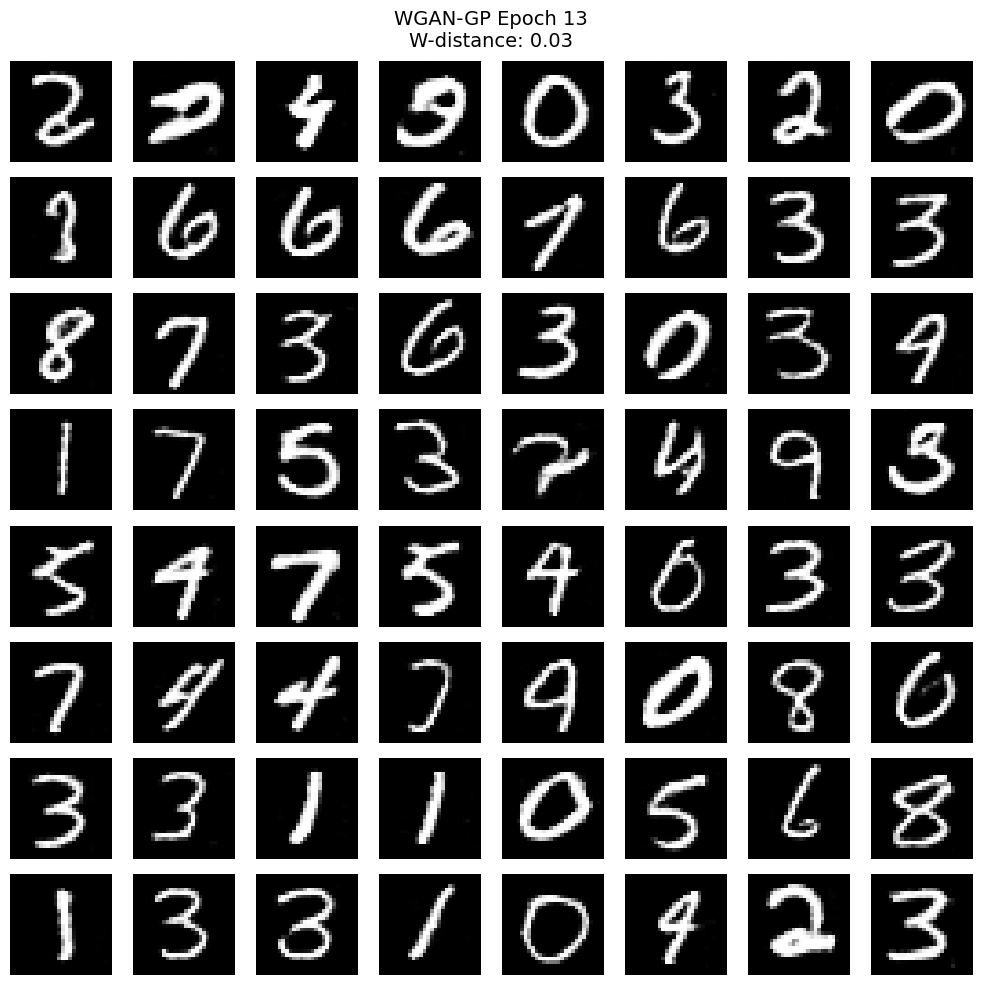

Epoch 14/15: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s, C=0.12, W=-0.10, G=6.58, GP=0.00]



Epoch 14:
  W-distance: 0.040 (target: ~0)
  Critic Loss: -0.019
  Generator Loss: 7.202
  Gradient Penalty: 0.002
  LR: 1.51e-04


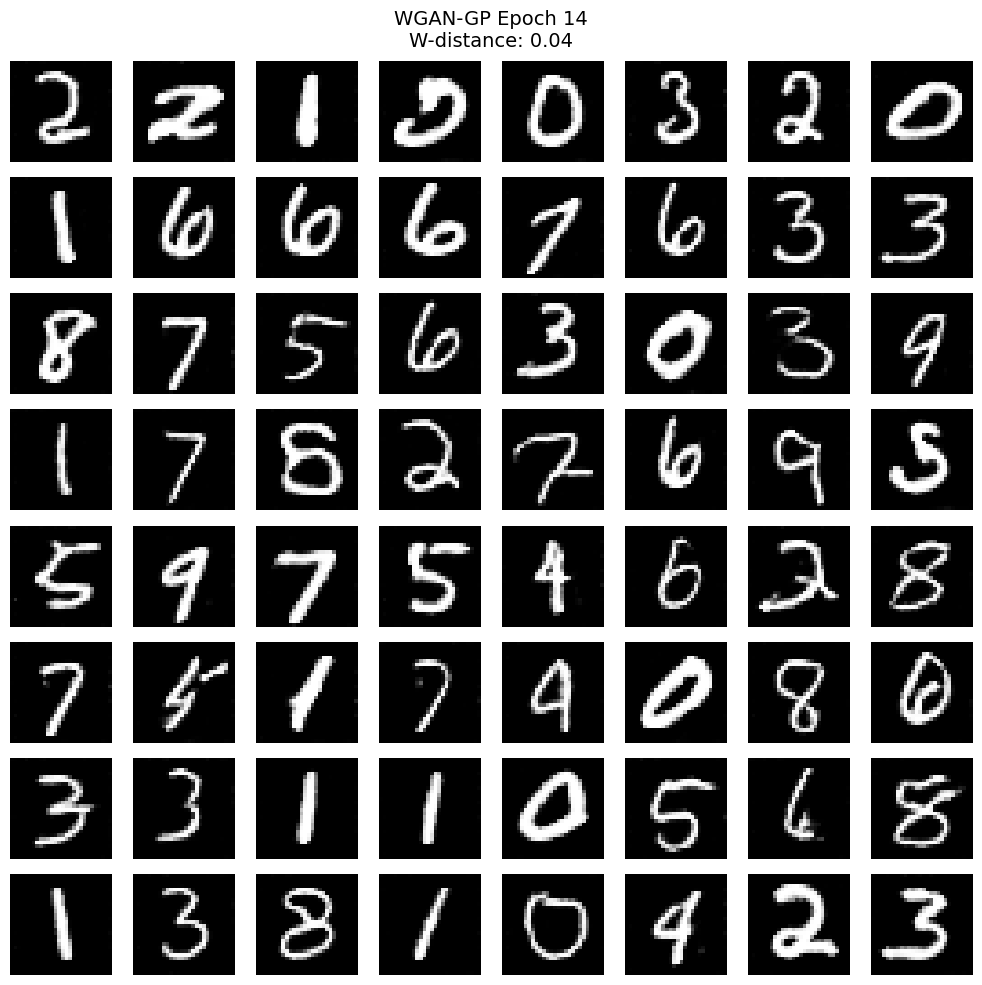

Epoch 15/15: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s, C=0.16, W=-0.14, G=6.86, GP=0.00]



Epoch 15:
  W-distance: 0.047 (target: ~0)
  Critic Loss: -0.024
  Generator Loss: 7.080
  Gradient Penalty: 0.002
  LR: 1.48e-04


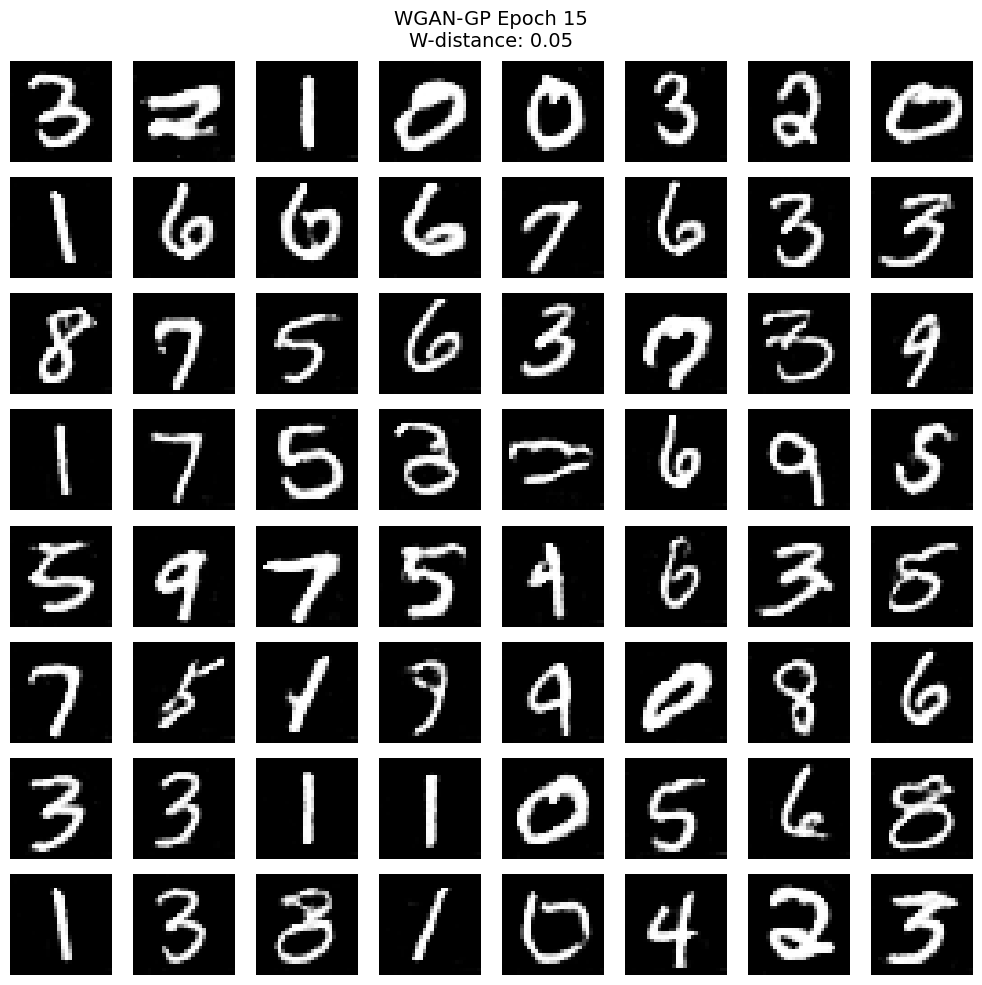

In [30]:
# ============================================================================
# 8. TRAIN WGAN-GP
# ============================================================================

# Training parameters
num_epochs = 15
n_critic = 2 #5  # Critic updates per generator update
lambda_gp =  1000 #10  # Gradient penalty coefficient

print("\n" + "="*60)
print("TRAINING WGAN-GP")
print("="*60)

# generator, critic, g_losses, c_losses, w_distances = train_wgan_gp(
#     generator=generator,
#     critic=critic,
#     dataloader=dataloader,
#     num_epochs=num_epochs,
#     z_dim=z_dim,
#     n_critic=n_critic,
#     lambda_gp=lambda_gp,
#     sample_interval=200
# )

generator, critic, g_losses, c_losses, w_distances ,_ = train_wgan_gp_improved(
    generator=generator,
    critic=critic,
    dataloader=dataloader,
    num_epochs=num_epochs,
    z_dim=z_dim,
    n_critic=n_critic,
    lambda_gp=lambda_gp,
    sample_interval=200
)

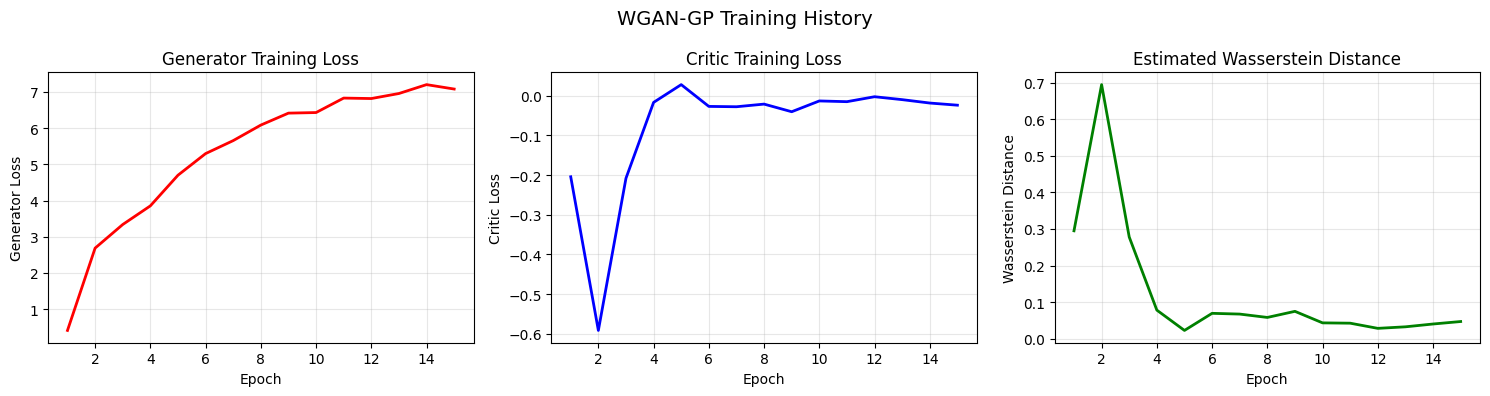


FINAL GENERATED SAMPLES


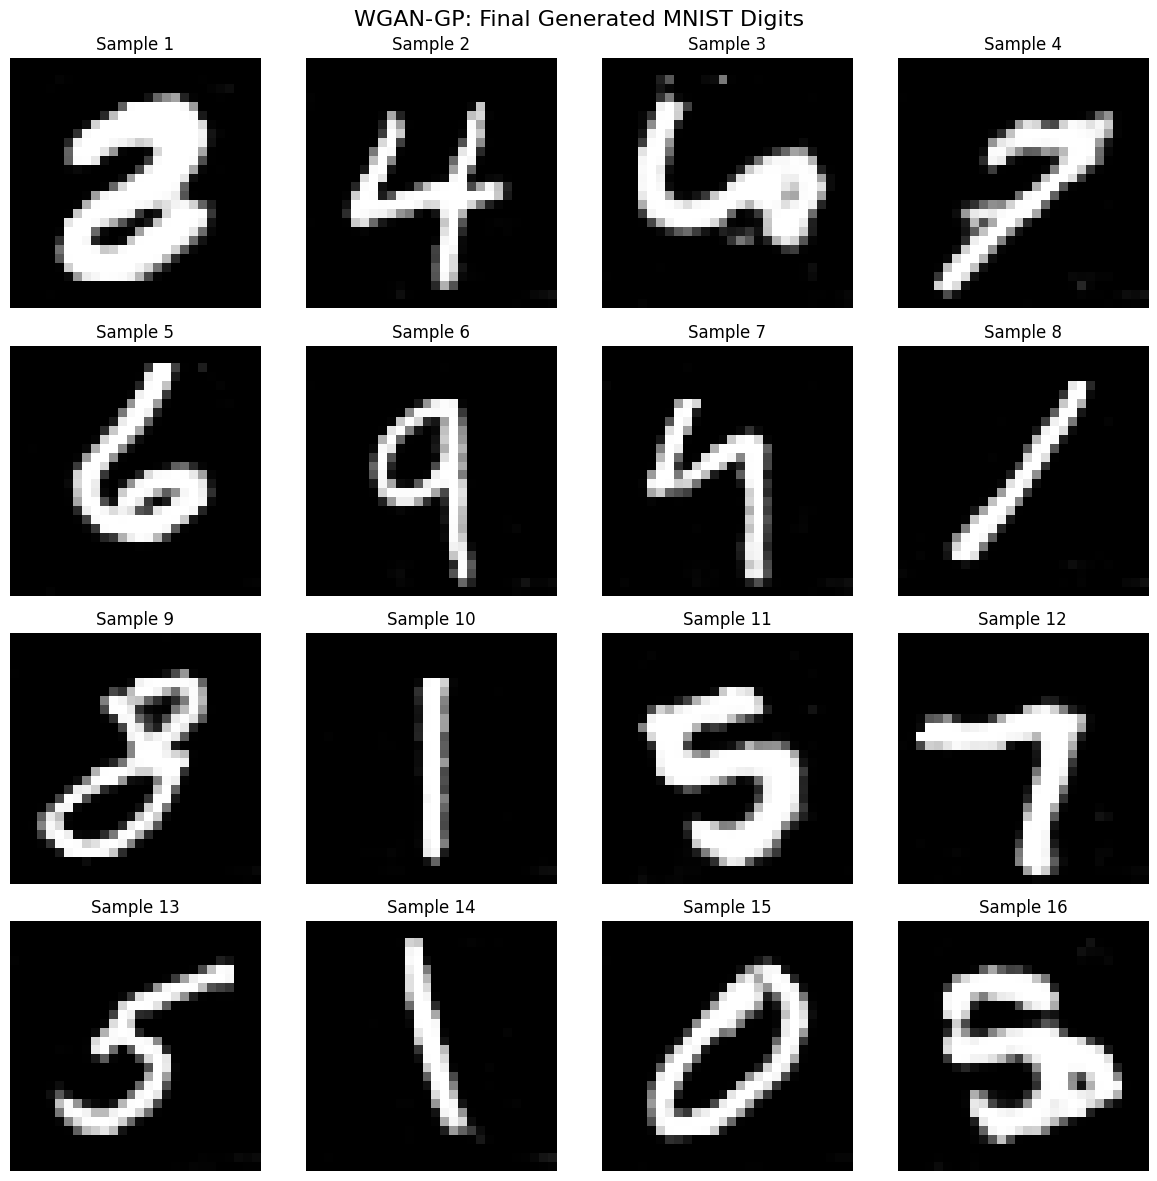


LATENT SPACE INTERPOLATION


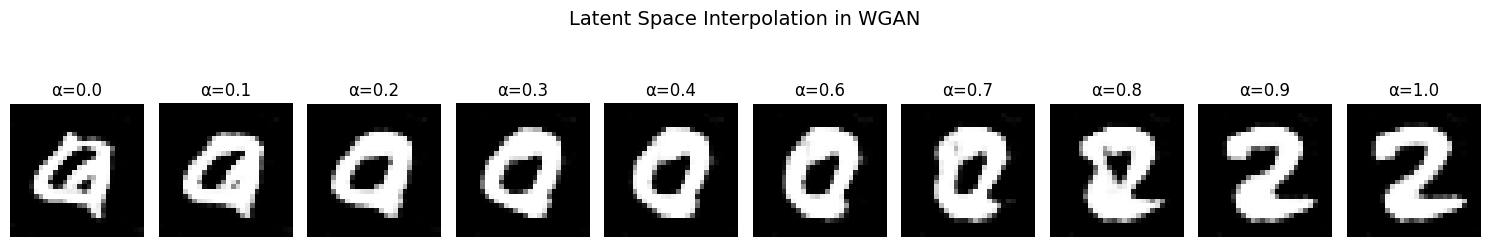

In [34]:
# ============================================================================
# 9. VISUALIZE RESULTS
# ============================================================================

# Plot training history
plot_training_history(g_losses, c_losses, w_distances)
 
# Generate final samples
print("\n" + "="*60)
print("FINAL GENERATED SAMPLES")
print("="*60)

generator.eval()
with torch.no_grad():
    # Generate multiple sets
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
    for i in range(4):
        for j in range(4):
            # Generate new noise
            noise = torch.randn(1, z_dim, device=device)
            gen_img = generator(noise).detach().cpu()
            gen_img = (gen_img + 1) / 2  # Rescale to [0, 1]
            
            axes[i, j].imshow(gen_img[0, 0], cmap='gray', vmin=0, vmax=1)
            axes[i, j].axis('off')
            axes[i, j].set_title(f'Sample {i*4 + j + 1}')
    
    plt.suptitle('WGAN-GP: Final Generated MNIST Digits', fontsize=16)
    plt.tight_layout()
    plt.savefig('/kaggle/working/wgan_final_samples.png')
    plt.show()

# ============================================================================
# 10. INTERPOLATION IN LATENT SPACE
# ============================================================================

def interpolate_latent_space(generator, z_dim=100, num_steps=10):
    """Interpolate between two points in latent space"""
    generator.eval()
    
    # Two random points in latent space
    z1 = torch.randn(1, z_dim, device=device)
    z2 = torch.randn(1, z_dim, device=device)
    
    # Interpolate
    interpolated = []
    for alpha in np.linspace(0, 1, num_steps):
        z = alpha * z1 + (1 - alpha) * z2
        with torch.no_grad():
            img = generator(z).detach().cpu()
            img = (img + 1) / 2  # Rescale
            interpolated.append(img)
    
    # Plot interpolation
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
    for i, (ax, img) in enumerate(zip(axes, interpolated)):
        ax.imshow(img[0, 0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f'α={i/(num_steps-1):.1f}')
    
    plt.suptitle('Latent Space Interpolation in WGAN', fontsize=14)
    plt.tight_layout()
    plt.savefig('/kaggle/working/wgan_latent_interpolation.png')
    plt.show()
    
    return interpolated

print("\n" + "="*60)
print("LATENT SPACE INTERPOLATION")
print("="*60)
imd = interpolate_latent_space(generator, z_dim=z_dim)

In [35]:

# ============================================================================
# 12. SAVE MODELS
# ============================================================================

print("\n" + "="*60)
print("SAVING MODELS")
print("="*60)

# Save generator and critic
torch.save({
    'epoch': num_epochs,
    'generator_state_dict': generator.state_dict(),
    'critic_state_dict': critic.state_dict(),
    'g_optimizer_state_dict': None,  # You might want to save optimizer states too
    'c_optimizer_state_dict': None,
    'g_losses': g_losses,
    'c_losses': c_losses,
    'w_distances': w_distances,
    'z_dim': z_dim
}, '/kaggle/working/wgan_gp_mnist.pth')

print("Models saved to '/kaggle/working/wgan_gp_mnist.pth'")


SAVING MODELS
Models saved to '/kaggle/working/wgan_gp_mnist.pth'



Testing loaded model...


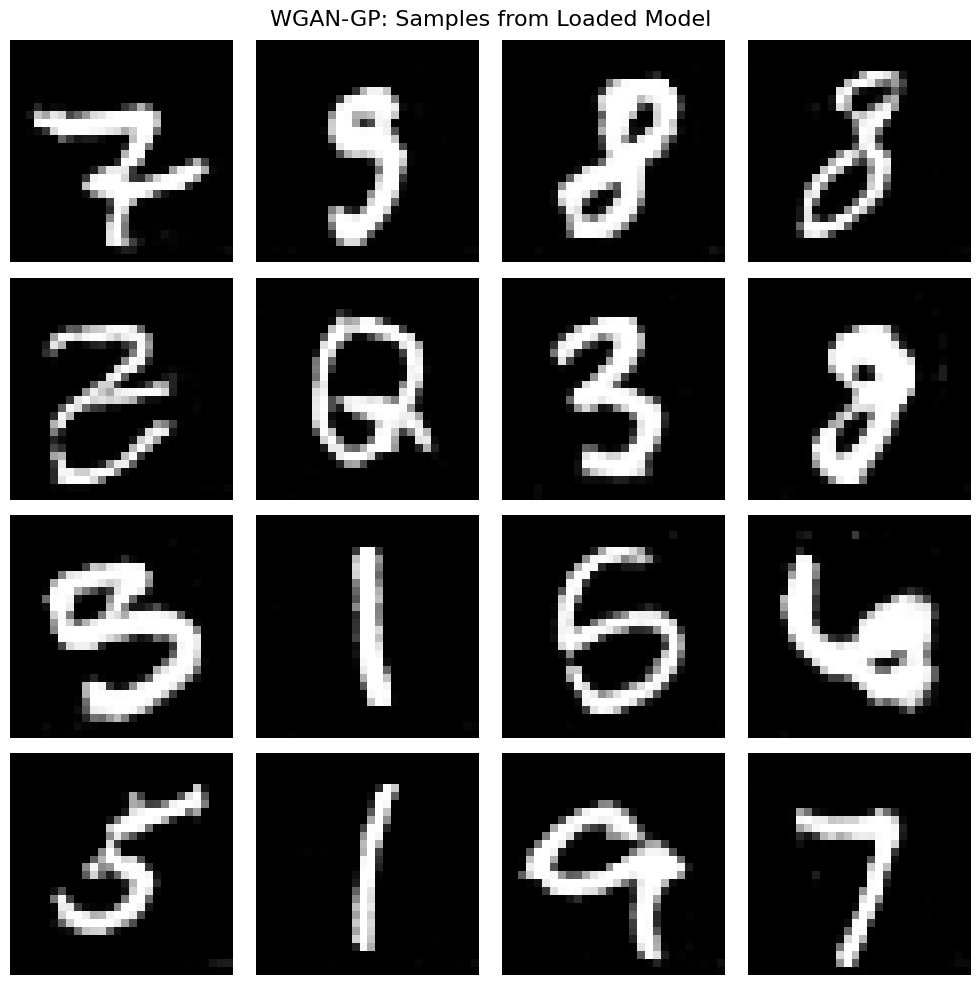

In [37]:

# ============================================================================
# 13. LOAD AND TEST SAVED MODELS
# ============================================================================

def load_and_test_model(model_path):
    """Load saved model and generate samples"""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create new models
    loaded_generator = GeneratorComplex(z_dim=checkpoint['z_dim']).to(device)
    loaded_generator.load_state_dict(checkpoint['generator_state_dict'])
    loaded_generator.eval()
    
    # Generate samples
    with torch.no_grad():
        noise = torch.randn(16, checkpoint['z_dim'], device=device)
        samples = loaded_generator(noise).detach().cpu()
        samples = (samples + 1) / 2
    
    # Plot
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i, 0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    
    plt.suptitle('WGAN-GP: Samples from Loaded Model', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return loaded_generator

print("\nTesting loaded model...")
loaded_generator = load_and_test_model('/kaggle/working/wgan_gp_mnist.pth')


GAN vs WGAN-GP COMPARISON
            Aspect    Vanilla GAN                WGAN-GP
      Loss Meaning Not meaningful ≈ Wasserstein distance
Training Stability       Unstable                 Stable
     Mode Collapse         Common                   Rare
   Hyperparameters      Sensitive                 Robust
       Convergence Hard to detect        Easy to monitor


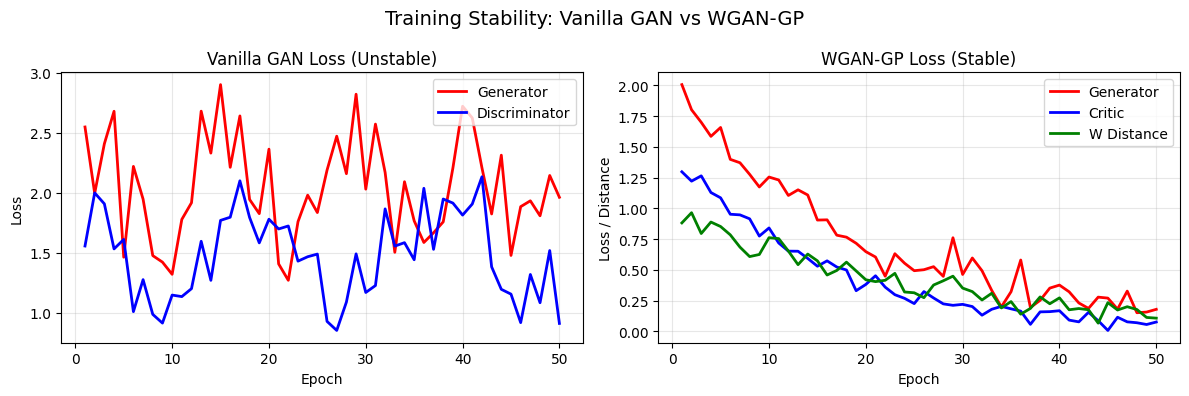

In [38]:
# ============================================================================
# 14. COMPARISON WITH VANILLA GAN
# ============================================================================

def compare_gan_vs_wgan():
    """Compare training stability of Vanilla GAN vs WGAN-GP"""
    # This is a conceptual comparison
    print("\n" + "="*60)
    print("GAN vs WGAN-GP COMPARISON")
    print("="*60)
    
    comparison = {
        'Aspect': ['Loss Meaning', 'Training Stability', 'Mode Collapse', 'Hyperparameters', 'Convergence'],
        'Vanilla GAN': ['Not meaningful', 'Unstable', 'Common', 'Sensitive', 'Hard to detect'],
        'WGAN-GP': ['≈ Wasserstein distance', 'Stable', 'Rare', 'Robust', 'Easy to monitor']
    }
    
    import pandas as pd
    df = pd.DataFrame(comparison)
    print(df.to_string(index=False))
    
    # Visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Simulated loss curves
    epochs = range(1, 51)
    
    # Vanilla GAN (unstable)
    gan_g_loss = [2.0 + 0.5*np.sin(i/2) + 0.3*np.random.randn() for i in epochs]
    gan_d_loss = [1.5 + 0.4*np.cos(i/3) + 0.2*np.random.randn() for i in epochs]
    
    # WGAN-GP (stable)
    wgan_g_loss = [2.0*np.exp(-i/20) + 0.1*np.random.randn() for i in epochs]
    wgan_d_loss = [1.5*np.exp(-i/15) + 0.05*np.random.randn() for i in epochs]
    wgan_w_dist = [1.0*np.exp(-i/25) + 0.05*np.random.randn() for i in epochs]
    
    axes[0].plot(epochs, gan_g_loss, 'r-', label='Generator', linewidth=2)
    axes[0].plot(epochs, gan_d_loss, 'b-', label='Discriminator', linewidth=2)
    axes[0].set_title('Vanilla GAN Loss (Unstable)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, wgan_g_loss, 'r-', label='Generator', linewidth=2)
    axes[1].plot(epochs, wgan_d_loss, 'b-', label='Critic', linewidth=2)
    axes[1].plot(epochs, wgan_w_dist, 'g-', label='W Distance', linewidth=2)
    axes[1].set_title('WGAN-GP Loss (Stable)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss / Distance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('Training Stability: Vanilla GAN vs WGAN-GP', fontsize=14)
    plt.tight_layout()
    plt.savefig('/kaggle/working/gan_vs_wgan_comparison.png')
    plt.show()

compare_gan_vs_wgan()

In [39]:

# ============================================================================
# 15. CONCLUSION
# ============================================================================

print("\n" + "="*60)
print("WGAN-GP TRAINING COMPLETE!")
print("="*60)

print("\n✅ Key Advantages of WGAN-GP over Vanilla GAN:")
print("1. ✅ Meaningful loss metric (≈ Wasserstein distance)")
print("2. ✅ More stable training")
print("3. ✅ Less prone to mode collapse")
print("4. ✅ Better gradient flow (no vanishing gradients)")
print("5. ✅ Easier hyperparameter tuning")

print("\n📊 Expected Results:")
print(f"- After {num_epochs} epochs, you should see:")
print("  • Clear MNIST digits (not blurry)")
print("  • Diverse digits (0-9 all represented)")  
print("  • Smooth latent space interpolation")

print("\n🎯 Next Steps:")
print("1. Try different architectures (deeper networks)")
print("2. Experiment with different λ values for gradient penalty")
print("3. Implement WGAN with weight clipping (original paper)")
print("4. Try conditional WGAN for controlled digit generation")
print("5. Apply to more complex datasets (CIFAR-10, CelebA)")


WGAN-GP TRAINING COMPLETE!

✅ Key Advantages of WGAN-GP over Vanilla GAN:
1. ✅ Meaningful loss metric (≈ Wasserstein distance)
2. ✅ More stable training
3. ✅ Less prone to mode collapse
4. ✅ Better gradient flow (no vanishing gradients)
5. ✅ Easier hyperparameter tuning

📊 Expected Results:
- After 15 epochs, you should see:
  • Clear MNIST digits (not blurry)
  • Diverse digits (0-9 all represented)
  • Smooth latent space interpolation

🎯 Next Steps:
1. Try different architectures (deeper networks)
2. Experiment with different λ values for gradient penalty
3. Implement WGAN with weight clipping (original paper)
4. Try conditional WGAN for controlled digit generation
5. Apply to more complex datasets (CIFAR-10, CelebA)
